In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from math import sqrt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import shap

## Data preparation

In [2]:
df = pd.read_csv('no_corr_pt_dataset.csv')

In [3]:
y = df.Shift.to_numpy()
X = df.drop(['Complex', 'Shift', 'Source_doi', 'Brutto', 'Charge_class', 'Geometry', 'Ligand', 'Smiles'], axis=1)

columns = X.columns
X = X.to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler_train = StandardScaler()

scaler_train.fit(X_train)
scaler_train.fit(X_test)

X_train_norm = scaler_train.transform(X_train)
X_test_norm = scaler_train.transform(X_test)

## Some useful functions

In [6]:
def evaluate_res(model, X_test, y_test):
    residuals = (y_test - model.predict(X_test))
    rmsd = sqrt(np.sum(residuals ** 2) / float(len(y_test)))
    print('RMSD = {:0.2f} ppm'.format(rmsd))   
    return rmsd


def plot_rmsd(model, X, y):
    plt.plot(y, y, color='r', linestyle='-', linewidth=3)
    plt.plot(y, model.predict(X), linestyle='none', marker='o')

    plt.xlabel("Exp. δ")
    plt.ylabel("Pred. δ")
    plt.show()
    
    return evaluate_res(model, X, y)

In [7]:
def tune_hyperparam(estimator, grid, X, y):
    
    est_random = RandomizedSearchCV(estimator=estimator, param_distributions = grid, n_iter = 100, 
                                    cv = 5, verbose=2, random_state=42, n_jobs = -1)
    est_random.fit(X, y)
    print(est_random.best_params_)
    print('Mean of R2', est_random.best_score_)
    
    return est_random.best_estimator_

In [40]:
def evaluate(estimator, X, y, n_splits, scoring):
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    
    if scoring == 'r2':
        scores = scores
#         print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    if scoring == 'neg_mean_absolute_error':
        scores = [-i for i in scores]
#         print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    if scoring == 'neg_mean_squared_error':
        scores = [np.sqrt(-i) for i in scores]
#         print('Mean =', np.mean(scores), 'Std =', np.std(scores), 'Min =', np.min(scores))
        
    return {'Mean':np.mean(scores), 'Std': np.std(scores), 'Min': np.min(scores)}

## Models: Random Forest, Ridge regressor, SVR

### Hyperprameter tuning by use of grid search

In [9]:
#Random forest grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 205, num = 22)]
max_depth.append(None)
min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
warm_start = [True, False]
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'warm_start': warm_start}

In [10]:
#Ridge regression grid
alpha = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
coef0 = np.linspace(1.e-10, 1, 50)
degree = [0, 1, 2, 3, 4]
gamma = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
kernel = ['laplacian', 'RBF', 'polynomial', 'exponential chi2', 'sigmoid']

grid_ridge = {'alpha': alpha,
         'coef0': coef0,
         'degree': degree,
         'gamma': gamma,
         'kernel': kernel}

In [11]:
#SVR grid
C = [10000, 100000, 1000000, 10000000]
coef0 = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
degree = [1, 2, 3, 4, 5]
epsilon = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
gamma = ['scale', 'auto']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
tol = [1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
max_iter = 1000000

grid_svr = {'C' : C,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'tol': tol}

In [12]:
rf = RandomForestRegressor()
ridge = KernelRidge()
svr = SVR(max_iter=max_iter)
estimators = {rf: grid_rf, ridge: grid_ridge, svr: grid_svr}

In [13]:
best_estim = []
for i, j in estimators.items():
    best_estim.append(tune_hyperparam(i, j, X_train_norm, y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   1.8s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.1s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1000, warm_start=False; total time=   3.0s
[

[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=843, warm_start=True; total time=   2.7s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   1.7s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   1.0s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples

[CV] END bootstrap=True, max_depth=205, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=322, warm_start=True; total time=   1.0s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   2.9s
[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.1s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.1s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1000, warm_start=False; total time=   3.1s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_sampl

[CV] END bootstrap=False, max_depth=43, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=843, warm_start=False; total time=   2.5s[CV] END bootstrap=False, max_depth=147, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1000, warm_start=True; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=687, warm_start=False; total time=   1.8s
[CV] END bootstrap=False, max_depth=176, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=322, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=374, warm_start=True; total time=   1.1s
[CV] END bootstrap=False, max_depth=138, max_features=auto, min_sam


40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/miniconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/miniconda3/lib/python3.7/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt

{'warm_start': True, 'n_estimators': 791, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 109, 'bootstrap': False}
Mean of R2 0.9589620440995622
Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END bootstrap=True, max_depth=205, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=322, warm_start=True; total time=   1.0s
[CV] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=270, warm_start=True; total time=   0.9s
[CV] END bootstrap=True, max_depth=128, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=166, warm_start=True; total time=   0.2s
[CV] END bootstrap=True, max_depth=128, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=166, warm_start=True; total time=   0.2s
[CV] END bootstrap=False, max_depth=43, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=843, warm_start=False; tota

[CV] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=843, warm_start=False; total time=   2.5s
[CV] END bootstrap=True, max_depth=157, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=895, warm_start=False; total time=   3.5s
[CV] END bootstrap=True, max_depth=33, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=322, warm_start=True; total time=   1.5s
[CV] END bootstrap=True, max_depth=33, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=322, warm_start=True; total time=   1.4s
[CV] END bootstrap=True, max_depth=109, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=635, warm_start=False; total time=   2.2s
[CV] END bootstrap=False, max_depth=81, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=478, warm_start=False; total time=   1.6s
[CV] END bootstrap=False, max_depth=81, max_features=auto, min_samples_lea


185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/kernel_ridge.py", line 197, in fit
    K = self._get_kernel(X)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/kernel_ridge.py", line 155, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py", line 2051, in pairw

{'kernel': 'laplacian', 'gamma': 0.001, 'degree': 4, 'coef0': 0.020408163363265307, 'alpha': 1e-08}
Mean of R2 0.9855843105116842
Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END bootstrap=True, max_depth=81, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=374, warm_start=True; total time=   2.3s
[CV] END bootstrap=True, max_depth=195, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=635, warm_start=False; total time=   3.2s
[CV] END bootstrap=True, max_depth=195, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=635, warm_start=False; total time=   4.5s
[CV] END bootstrap=True, max_depth=71, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=583, warm_start=True; total time=   3.0s
[CV] END bootstrap=True, max_depth=24, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=843, warm_start=True; total time=   3.7s
[CV] END bootstrap=True, max_depth=9

[CV] END alpha=1.0, coef0=0.06122448988979592, degree=3, gamma=1e-05, kernel=RBF; total time=   0.0s
[CV] END bootstrap=False, max_depth=185, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=843, warm_start=False; total time=   5.2s
[CV] END bootstrap=True, max_depth=81, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=374, warm_start=True; total time=   2.3s
[CV] END bootstrap=True, max_depth=195, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=635, warm_start=False; total time=   3.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=218, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=218, warm_start=True; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=218, warm_star

[CV] END alpha=1e-05, coef0=0.020408163363265307, degree=1, gamma=0.01, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.06122448988979592, degree=3, gamma=1e-05, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.04081632662653061, degree=0, gamma=1e-08, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.04081632662653061, degree=0, gamma=1e-08, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.04081632662653061, degree=0, gamma=1e-08, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.04081632662653061, degree=0, gamma=1e-08, kernel=RBF; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.04081632662653061, degree=0, gamma=1e-08, kernel=RBF; total time=   0.0s
[CV] END alpha=0.1, coef0=0.6938775510510204, degree=2, gamma=1e-07, kernel=polynomial; total time=   0.0s
[CV] END alpha=0.1, coef0=0.6938775510510204, degree=2, gamma=1e-07, kernel=polynomial; total time=   0.0s
[CV] END alpha=0.1, coef0=0.6938775510510204, degree=2,

[CV] END C=10000000, coef0=1e-05, degree=2, epsilon=0.01, gamma=scale, kernel=rbf, tol=1e-07; total time=   0.3s
[CV] END alpha=1e-06, coef0=0.14285714294285715, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1e-06, coef0=0.14285714294285715, degree=4, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6326530612612244, degree=4, gamma=1e-09, kernel=polynomial; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.9591836734734693, degree=4, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.9591836734734693, degree=4, gamma=1.0, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=0.0001

[CV] END alpha=0.01, coef0=0.22448979599591837, degree=0, gamma=0.01, kernel=laplacian; total time=   0.0s
[CV] END alpha=0.0001, coef0=0.8571428571571429, degree=4, gamma=1e-06, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=0.01, coef0=0.2857142857857143, degree=3, gamma=1e-07, kernel=RBF; total time=   0.0s
[CV] END alpha=0.01, coef0=0.2857142857857143, degree=3, gamma=1e-07, kernel=RBF; total time=   0.0s
[CV] END alpha=0.01, coef0=0.2857142857857143, degree=3, gamma=1e-07, kernel=RBF; total time=   0.0s
[CV] END alpha=0.01, coef0=0.2857142857857143, degree=3, gamma=1e-07, kernel=RBF; total time=   0.0s
[CV] END alpha=0.01, coef0=0.2857142857857143, degree=3, gamma=1e-07, kernel=RBF; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.4489795918918367, degree=3, gamma=1.0, kernel=RBF; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.4489795918918367, degree=3, gamma=1.0, kernel=RBF; total time=   0.0s
[CV] END alpha=1e-08, coef0=0.4489795918918367, degree=3, gamma=1.0, ker

[CV] END alpha=0.0001, coef0=0.48979591841836734, degree=4, gamma=1e-07, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-05, coef0=0.020408163363265307, degree=1, gamma=0.01, kernel=polynomial; total time=   0.0s
[CV] END alpha=1e-05, coef0=0.020408163363265307, degree=1, gamma=0.01, kernel=polynomial; total time=   0.0s
[CV] END alpha=1.0, coef0=0.2857142857857143, degree=0, gamma=1e-08, kernel=laplacian; total time=   0.0s
[CV] END alpha=1.0, coef0=0.2857142857857143, degree=0, gamma=1e-08, kernel=laplacian; total time=   0.0s
[CV] END alpha=1.0, coef0=0.2857142857857143, degree=0, gamma=1e-08, kernel=laplacian; total time=   0.0s
[CV] END alpha=1.0, coef0=0.2857142857857143, degree=0, gamma=1e-08, kernel=laplacian; total time=   0.0s
[CV] END alpha=1.0, coef0=0.2857142857857143, degree=0, gamma=1e-08, kernel=laplacian; total time=   0.0s
[CV] END alpha=1.0, coef0=0.6734693877877551, degree=3, gamma=1e-05, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-06

[CV] END C=10000, coef0=0.1, degree=2, epsilon=1.0, gamma=scale, kernel=sigmoid, tol=0.01; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.265306122522449, degree=2, gamma=1e-08, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=1e-09, coef0=0.265306122522449, degree=2, gamma=1e-08, kernel=exponential chi2; total time=   0.0s
[CV] END alpha=0.01, coef0=0.5714285714714286, degree=0, gamma=0.0001, kernel=polynomial; total time=   0.0s
[CV] END C=1000000, coef0=1e-05, degree=4, epsilon=1e-06, gamma=scale, kernel=sigmoid, tol=1e-09; total time=   0.0s
[CV] END C=1000000, coef0=1e-05, degree=4, epsilon=1e-06, gamma=scale, kernel=sigmoid, tol=1e-09; total time=   0.0s
[CV] END C=10000000, coef0=1.0, degree=2, epsilon=1e-09, gamma=auto, kernel=rbf, tol=1e-08; total time=   0.1s
[CV] END C=10000000, coef0=1.0, degree=2, epsilon=1e-09, gamma=auto, kernel=rbf, tol=1e-08; total time=   0.1s
[CV] END C=1000000, coef0=1e-05, degree=2, epsilon=0.01, gamma=scale, kernel=sigmoid, tol=1e-10; 

[CV] END C=10000000, coef0=0.01, degree=1, epsilon=1e-06, gamma=auto, kernel=sigmoid, tol=1e-06; total time=   0.0s{'tol': 1e-10, 'kernel': 'poly', 'gamma': 'scale', 'epsilon': 1e-09, 'degree': 3, 'coef0': 1.0, 'C': 1000000}
Mean of R2 0.9503409584345148


Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [14]:
best_estim

[RandomForestRegressor(bootstrap=False, max_depth=109, max_features='sqrt',
                       min_samples_split=3, n_estimators=791, warm_start=True),
 KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
             kernel='laplacian'),
 SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
     tol=1e-10)]

### Training and evaluation of models by use of cross-validation

In [41]:
#Determination coefficient
res_r2 = []
for i in best_estim:
    res_r2.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='r2'))
res_df_r2 = pd.DataFrame(res_r2, index=['RF', 'Ridge regr', 'SVR'])
res_df_r2

Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,Mean,Std,Min
RF,0.969091,0.011535,0.950724
Ridge regr,0.990951,0.006259,0.982819
SVR,0.948911,0.021058,0.918211


In [42]:
#MAE
res_mae = []
for i in best_estim:
    res_mae.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_absolute_error'))
res_df_mae = pd.DataFrame(res_mae, index=['RF', 'Ridge regr', 'SVR'])
res_df_mae

Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,Mean,Std,Min
RF,267.544546,26.355894,240.208878
Ridge regr,175.148831,57.757841,94.204570
SVR,364.765788,61.704209,286.269198


In [43]:
#RMSE
res_rmse = []
for i in best_estim:
    res_rmse.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_squared_error'))
res_df_rmse = pd.DataFrame(res_rmse, index=['RF', 'Ridge regr', 'SVR'])
res_df_rmse

Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,Mean,Std,Min
RF,491.982402,107.143006,317.212543
Ridge regr,261.686750,118.656018,109.449481
SVR,628.128561,123.406317,501.849900


RandomForestRegressor(bootstrap=False, max_depth=109, max_features='sqrt',
                      min_samples_split=3, n_estimators=791, warm_start=True)


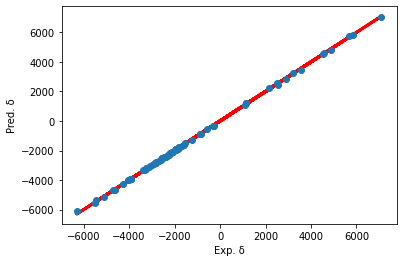

RMSD = 42.55 ppm


KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
            kernel='laplacian')


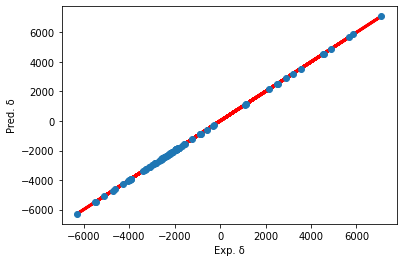

RMSD = 0.00 ppm


SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
    tol=1e-10)


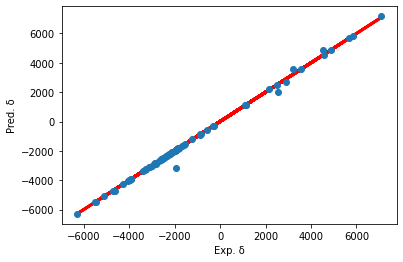

RMSD = 150.58 ppm




In [18]:
for i in best_estim:
    print(i)
    plot_rmsd(i, X_train_norm, y_train,)
    print('\n')

## Test the model on held-out data

RandomForestRegressor(bootstrap=False, max_depth=109, max_features='sqrt',
                      min_samples_split=3, n_estimators=791, warm_start=True)


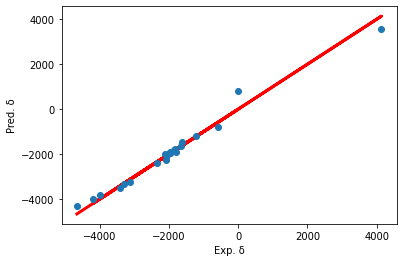

RMSD = 245.31 ppm


KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
            kernel='laplacian')


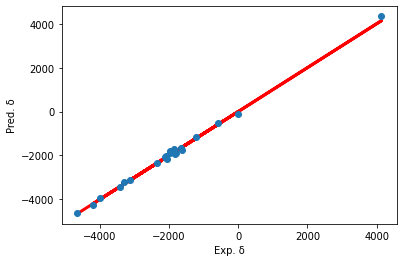

RMSD = 96.04 ppm


SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
    tol=1e-10)


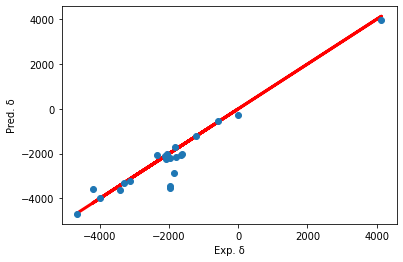

RMSD = 540.41 ppm




In [19]:
for i in best_estim:
    print(i)
    plot_rmsd(i, X_test_norm, y_test)
    print('\n')

## Models explanation

In [20]:
shap.initjs()
columns

Index(['Charge', 'Dipole', 'q', '1', '2', '3', '4', '5', '6', '7', '9', '11',
       '13', '14', '21', '23', '37', '40', '41', '42', '43', '46'],
      dtype='object')

### Random Forest

In [37]:
explainer_rf = shap.TreeExplainer(model=best_estim[0])
shap_values_rf = explainer_rf.shap_values(X_test_norm[0])

shap.force_plot(base_value=explainer_rf.expected_value, shap_values=shap_values_rf,
                features=X_test_norm[0], feature_names=columns)

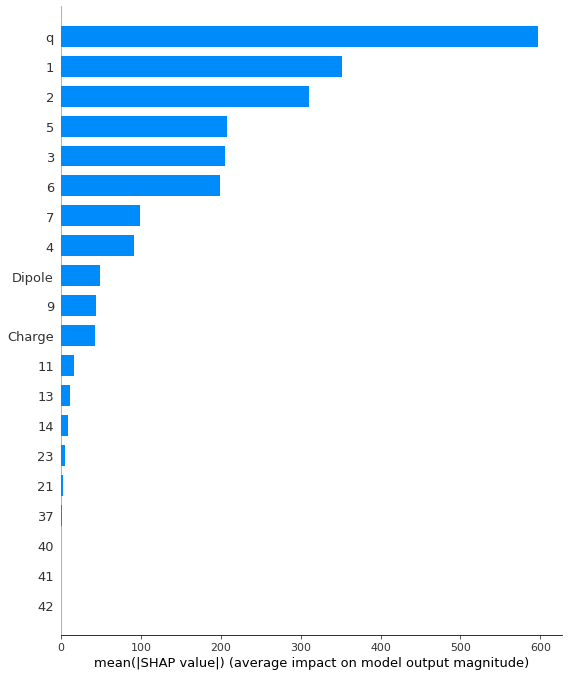

In [22]:
shap_values_rf = explainer_rf.shap_values(X_test_norm)
shap.summary_plot(shap_values_rf, X_test_norm, plot_type="bar", feature_names=columns)

### Laplacian kernel ridge regression

In [27]:
explainer_ridge = shap.KernelExplainer(model=best_estim[1].predict, data=X_train_norm)
shap_values_ridge = explainer_ridge.shap_values(X_test_norm[0])

shap.force_plot(base_value=explainer_ridge.expected_value, shap_values=shap_values_ridge,
                features=X_test_norm[0], feature_names=columns)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


  0%|          | 0/23 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

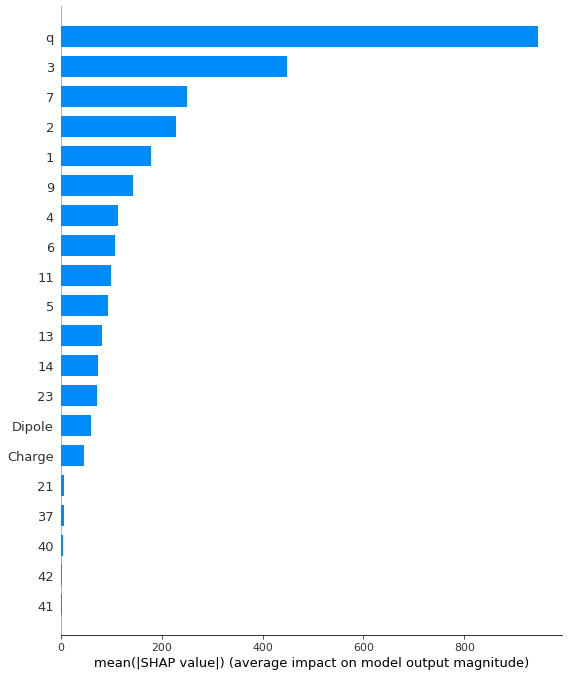

In [36]:
shap_values_ridge = explainer_ridge.shap_values(X_test_norm)
shap.summary_plot(shap_values_ridge, X_test_norm, plot_type="bar", feature_names = columns)

### SVR

In [29]:
explainer_svr = shap.KernelExplainer(model=best_estim[2].predict, data=X_train_norm)
shap_values_svr = explainer_svr.shap_values(X_test_norm[0])

shap.force_plot(base_value=explainer_svr.expected_value, shap_values=shap_values_ridge,
                features=X_test_norm[0], feature_names=columns)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


  0%|          | 0/23 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

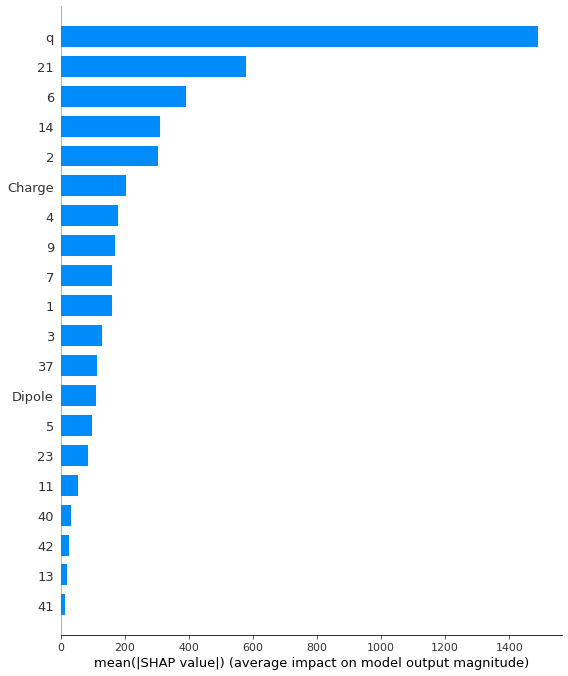

In [35]:
shap_values_svr = explainer_svr.shap_values(X_test_norm)
shap.summary_plot(shap_values_svr, X_test_norm, plot_type="bar", feature_names = columns)